<h2><font color="#004D7F" size=6>Módulo 4. Fase de tratamiento de datos</font></h2>



<h1><font color="#004D7F" size=5>2. Feature Selection</font></h1>

<br><br>
<div style="text-align: right">
<font color="#004D7F" size=3>Manuel Castillo-Cara</font><br>
<font color="#004D7F" size=3>Machine Learning con Python</font><br>

---

<h2><font color="#004D7F" size=5>Índice</font></h2>
<a id="indice"></a>

* [1. Introducción](#section1)
    * [1.1. CSV](#section11)
    * [1.1. Librerías](#section12)
* [2. Técnicas de Feature selection](#section2)
    * [2.1. Coeficiente de correlación](#section21)
    * [2.2. Características altamente correlacionadas](#section22)
    * [2.3. Eliminación Backward](#section23)
    * [2.4. Selección univariable](#section24)
    * [2.5. Eliminación recursiva de características](#section25)

In [2]:
# Permite ajustar la anchura de la parte útil de la libreta (reduce los márgenes)
from IPython.core.display import display, HTML
display(HTML("<style>.container{ width:98% }</style>"))

C:\Users\Cris2\AppData\Local\Temp\ipykernel_19264\1126351303.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


---

<a id="section1"></a>
# <font color="#004D7F"> 1. Introducción</font>

En resumen, feature selection, también llamado como selección de mejores características o atributos, es el proceso de seleccionar un subconjunto de características pertinentes (variables, predictores) para su uso en construcción de modelos. Las técnicas de feature selection son utilizadas por cuatro razones:
* Simplificación de modelos con el fin de hacerlas más sencillas de interpretar para los usuarios/investigadores.
* Menor tiempo de entrenamiento.
* Evitar la maldición de la dimensionalidad:
* Generalización realzada por reducir _overfitting_ (formalmente, reducción de varianza).

<a id="section11"></a>
## <font color="#004D7F"> 1.1. CSV</font>

En esta lección, se muestran varias métricas de evaluación de algoritmos diferentes para problemas de Machine Learning de clasificación y regresión. En cada código, el conjunto de datos se descarga directamente del repositorio de UCI Machine Learning.
* **Clasificación**: se usará el conjunto de datos de Pima Indians Diabetes. Este es un problema de clasificación binaria donde todas las características de entrada son numéricas.

In [34]:
# Clasification problem
import pandas as pd
filename = 'data/pima-indians-diabetes.data.csv'
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class'] 
df_cla = pd.read_csv(filename, names=names)
array = df_cla.values
X_cla = array[:,0:8]
Y_cla = array[:,8]

* **Regresión**: se usará el conjunto de datos Boston House Price. Este es un problema de regresión donde todas las características de entrada también son numéricas. En esta práctica lo trabajaremos directamente desde scikit-learn.

In [37]:
# Ya no esixte el dataset público por lo que lo cargamos directamente de nuestro CSV
# Regression problem
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
filename_reg = 'data/housing.csv'
names_reg = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO',
'B', 'LSTAT', 'MEDV']
df_reg = pd.read_csv(filename_reg, delim_whitespace=True, names=names_reg) 
array_reg = df_reg.values
X_reg = array_reg[:,0:13]
y_reg = array_reg[:,13]

<a id="section12"></a>
## <font color="#004D7F"> 1.2. Librerías</font>

Por último vamos a declarar algunas librerías generales que ya hemos estado trabajando y que usaremos a lo largo de la sección.

In [41]:
#importing libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split

<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<a id="section2"></a>
# <font color="#004D7F"> 2. Técnicas de Feature selection</font>

la selección de las funciones correctas en sus datos puede significar la diferencia entre un rendimiento mediocre con largos tiempos de entrenamiento y un gran rendimiento con tiempos de entrenamiento cortos. Como dice el principio de Occam's Razor:

*Los modelos más simples son los mejores.*

<a id="section21"></a>
## <font color="#004D7F"> 2.1. Coeficiente de correlación </font>

Cuando hablamos de coeficiente de correlación conocemos que los números entre $+1$ y $-1$ representa la interacción y la dirección de la relación entre dos variables. Las correlaciones que están más cerca de $+1$ y $-1$ se encuentran más relacionadas y son más capaces de predecir con precisión. La idea es que aquellas características que tienen una alta correlación con la variable dependiente son predictores fuertes cuando se usan en un modelo.

Podemos observar que las características que añaden más información al atributo clase es _LSTAT_ y _RM;_ aunque para la técnica que tenemos que utilizar lo que necesitamos es poder descartar los que menos información añadan.

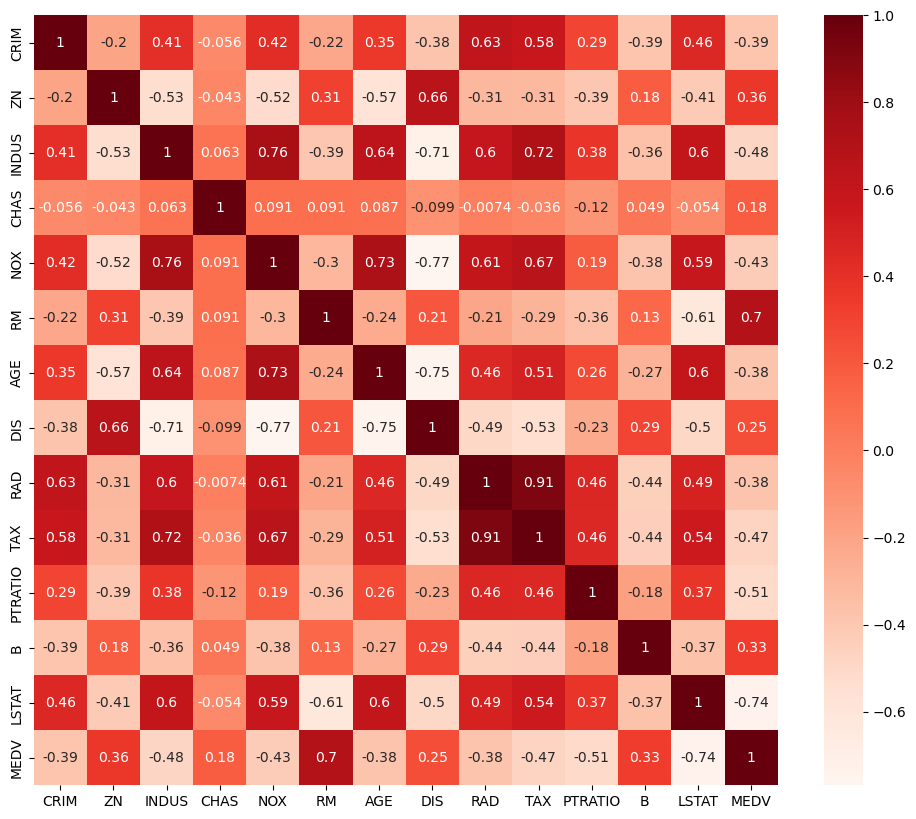

In [48]:
#Using Pearson Correlation
plt.figure(figsize=(12, 10))
corr = df_reg.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

In [49]:
# correlation with outpur variable
corr_target = abs(corr["MEDV"])
relevant_features = corr_target[corr_target > 0.5]
relevant_features

RM         0.695360
PTRATIO    0.507787
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

<a id="section22"></a>
## <font color="#004D7F"> 2.2. Características altamente correlacionadas entre si </font>

Al contrario del paquete Caret del lenguaje R, Python no tiene definida una librería con una función que nos agilice este este trabajo. Por tanto tendremos que crear una función que nos facilite este trabajo de recolección de características altamente correlacionadas.

En general, desea eliminar los atributos con una correlación absoluta de 0,75 o superior. es por esoque en el código anterior elimina las columnas _DIS_ y _NOX_ que tenían una correlación del -0,77.

In [60]:
# Create correlation matrix
corr_matrix = df_reg.corr().abs()
corr_matrix

# Select upper triangle of correlation matrix
# bool en la nueva versión se ha convertido en una propiedad (antes era "bool", ahora es "bool_")
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
to_drop

['NOX', 'DIS', 'TAX']

In [64]:
df_reg_withoutcorr = df_reg.drop(df_reg[to_drop], axis=1)
df_reg_withoutcorr

,CRIM,ZN,INDUS,CHAS,RM,AGE,RAD,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,6.575,65.2,1,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,6.421,78.9,2,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,7.185,61.1,2,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,6.998,45.8,3,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,7.147,54.2,3,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,6.593,69.1,1,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,6.120,76.7,1,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,6.976,91.0,1,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,6.794,89.3,1,21.0,393.45,6.48,22.0


<a id="section23"></a>
## <font color="#004D7F"> 2.3. Eliminación Backward </font>

Al principio le brindamos todas las características posibles al modelo. Verificamos el rendimiento del modelo y luego eliminamos iterativamente las características de peor rendimiento una por una hasta que el rendimiento general del modelo se encuentre en un rango aceptable.

La métrica de rendimiento utilizada aquí para evaluar el rendimiento de la característica es $p-value$. Si el valor $p$ está por encima de 0.05, eliminamos la característica, de lo contrario la conservamos.

Como podemos ver, la variable _AGE_ tiene un valor más alto de 0.9582293, que es mayor que 0.05. Además _INDUS_ también tiene un valor mayor a 0.05, por tanto, eliminaremos esta característica.

In [75]:
#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X_reg)
model = sm.OLS(y_reg, X_1).fit()
model.pvalues

array([3.28343850e-12, 1.08681010e-03, 7.78109688e-04, 7.38288071e-01,
       1.92503033e-03, 4.24564381e-06, 1.97944110e-18, 9.58229309e-01,
       6.01349110e-13, 5.07052902e-06, 1.11163672e-03, 1.30883513e-12,
       5.72859167e-04, 7.77691177e-23])

<a id="section24"></a>
## <font color="#004D7F"> 2.4. Selección univariable </font>

Las pruebas estadísticas se pueden usar para seleccionar aquellas características que tienen la relación más fuerte con la variable de salida. La biblioteca scikit-learn proporciona la clase _SelectKBest_ que se puede usar con un conjunto de diferentes pruebas estadísticas para seleccionar un número específico de características. 

Puede ver los puntajes para cada atributo y los 4 atributos elegidos (aquellos con los puntajes más altos): _plas, test, mass_ y _age._ Obtiene los nombres de los atributos elegidos asignando manualmente el índice de las 4 puntuaciones más altas al índice de los nombres de los atributos.

In [77]:
# Libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# feature extraction
test = SelectKBest(score_func=chi2, k = 4)
fit = test.fit(X_cla, Y_cla)
# summarize scores
print(list(df_cla.columns))
print(fit.scores_)
feaures = fit.transform(X_cla)
# summarize selected features
print(feaures)

['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
[ 111.51969064 1411.88704064   17.60537322   53.10803984 2175.56527292
  127.66934333    5.39268155  181.30368904]
[[148.    0.   33.6  50. ]
 [ 85.    0.   26.6  31. ]
 [183.    0.   23.3  32. ]
 ...
 [121.  112.   26.2  30. ]
 [126.    0.   30.1  47. ]
 [ 93.    0.   30.4  23. ]]


<div class="alert alert-block alert-info">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Más información en la documentación oficial sobre la clase [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html?highlight=selectkbest#sklearn.feature_selection.SelectKBest). 
</div> 

<a id="section25"></a>
## <font color="#004D7F"> 2.5. Eliminación recursiva de características </font>

La eliminación de características recursivas (RFE) funciona eliminando recursivamente los atributos y construyendo un modelo sobre los atributos que quedan. Utiliza la precisión del modelo para identificar qué atributos (y combinación de atributos) contribuyen más a predecir el atributo objetivo.

Puede ver que RFE eligió las 3 características principales como _preg, plas_ y _mass._ Estos están marcados como `True` en la matriz de soporte y marcados con una opción 1 en la matriz de clasificación. Nuevamente, puede asignar manualmente los índices de características a los índices de nombres de atributos.

In [79]:
# Libraries
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# feature extraction
model = LogisticRegression(solver='lbfgs', max_iter=1000)

## En la nueva versión establece que se tenga que indicar el parámetro "n_features_to_select"
## para indicar el número de características
rfe = RFE(model, n_features_to_select=3)
fit = rfe.fit(X_cla, Y_cla)

print(list(df_cla.columns))
print(f"Num Features: {fit.n_features_}")
print(f"Select Features: {fit.support_}")
print(f"Features ranking: {fit.ranking_}")

['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
Num Features: 3
Select Features: [ True False False False False  True  True False]
Features ranking: [1 2 4 6 5 1 1 3]


<div class="alert alert-block alert-info">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Más información en la documentación oficial sobre la clase [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE). 
</div> 

<div style="text-align: right"> <font size=5>
    <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a>
</font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>